In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid", palette="colorblind")
sns.set(rc={'figure.figsize':(11.7,8.27)})
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_hdf("data/sci.h5", 'table')

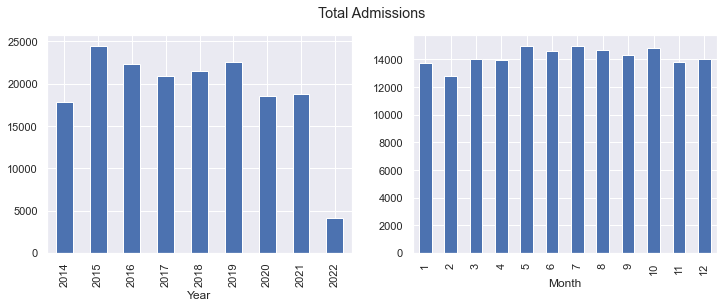

In [4]:
def total_admissions(df: pd.DataFrame, years=(2014, 2022), col='AdmissionDateTime'):
    dfc = df[df[col].dt.year.between(*years)][col]
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    fig.suptitle('Total Admissions')
    df[col].groupby(dfc.dt.year).count().plot.bar(ax=ax[0], xlabel='Year')
    df[col].groupby(dfc.dt.month).count().plot.bar(ax=ax[1], xlabel='Month')

total_admissions(df)

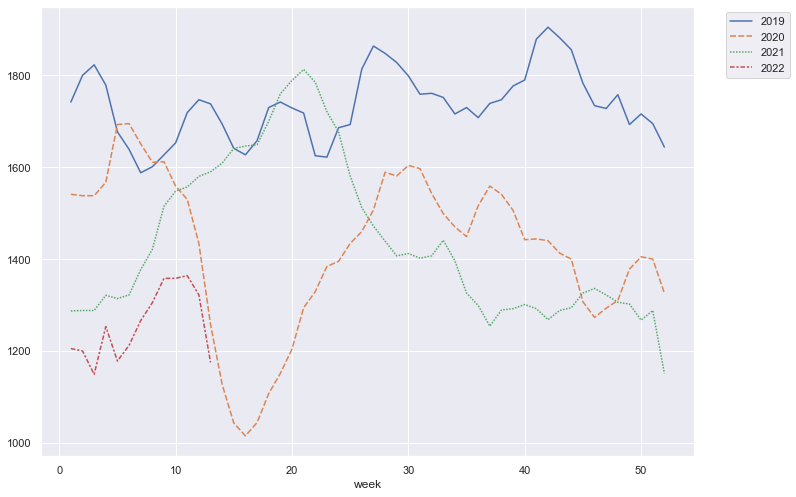

In [413]:
def monthly_admissions_per_year(df: pd.DataFrame, years=range(2019, 2023), col='AdmissionDateTime'):
    grouped = df[col].groupby(
        [df[col].dt.year, df[col].dt.isocalendar().week]
    ).count().drop(53, level=1)

    # Manual corrections due to week weirdness
    grouped.loc[2014, 52] += grouped.loc[2014, 1]
    grouped.loc[2022, 1] += grouped.loc[2022, 52]
    grouped.loc[2014, 1], grouped.loc[2022, 52] = np.nan, np.nan

    grouped = grouped.rolling(4).sum().unstack(level=0)
    
    sns.lineplot(
        data=grouped[years]
    )
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

monthly_admissions_per_year(df)

<AxesSubplot:xlabel='AdmissionDateTime'>

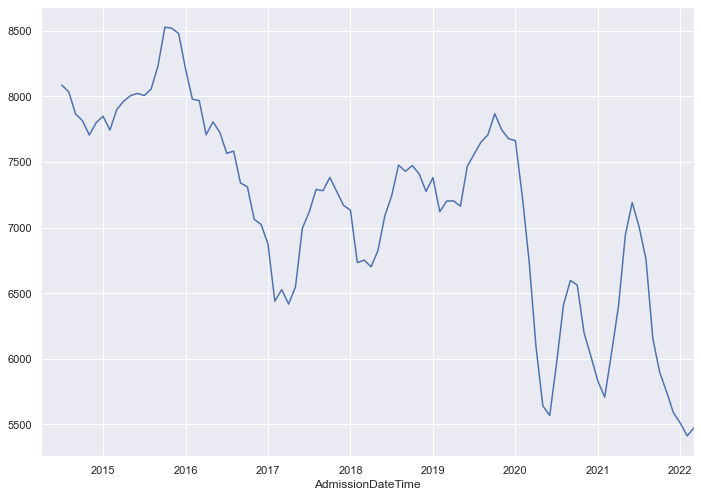

In [6]:
def quarterly_admissions_rolling(df: pd.DataFrame, col='AdmissionDateTime') -> pd.Series:
    return df[col].groupby(
        df[col].dt.to_period("M")
    ).count().rolling(4).sum()

quarterly_admissions_rolling(df).plot()

In [7]:
def period_count(df, period="M", col='AdmissionDateTime'):
    return df[col].groupby(
        df[col].dt.to_period(period)
    ).count()

<AxesSubplot:xlabel='AdmissionDateTime'>

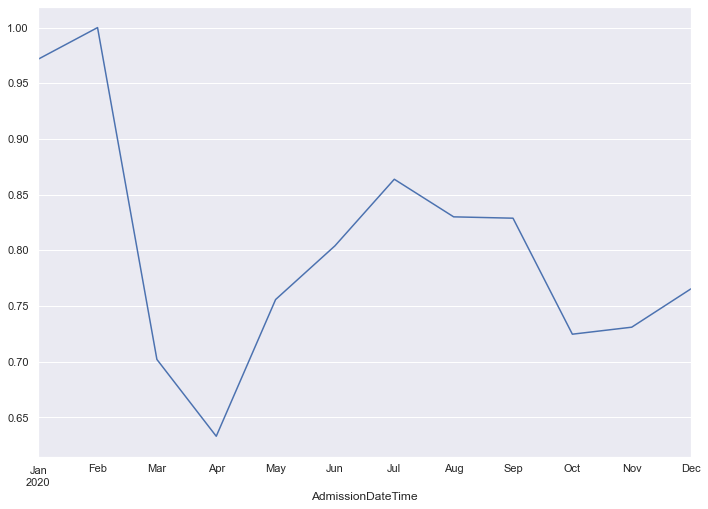

In [8]:
def compare_years(df, x = 2019, y=2020, baseline=2):
    x, y = min(x,y), max(x,y)
    months = period_count(df[df.AdmissionDateTime.dt.year.between(x,y)])
    base_x, base_y = \
        months.loc[pd.Period(freq="M", year=x, month=baseline)], months.loc[pd.Period(freq="M", year=y, month=baseline)]
    r = (months/months.shift(12))*(base_x/base_y)
    return r.dropna()
compare_years(df).plot()

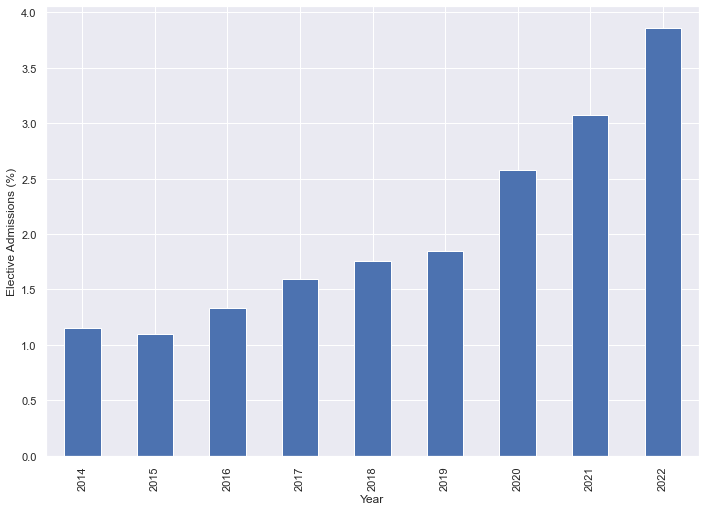

In [9]:
def elective_admissions_prop_yearly(df):
    grouped = df.groupby(
            [df.AdmissionDateTime.dt.year, df.ElectiveAdmission]
        ).SpellSerial.count()
    el, nonel = grouped.xs(True, level=1), grouped.xs(False, level=1)
    (el*100/(el+nonel)).plot.bar(xlabel='Year', ylabel='Elective Admissions (%)')
    
elective_admissions_prop_yearly(df)

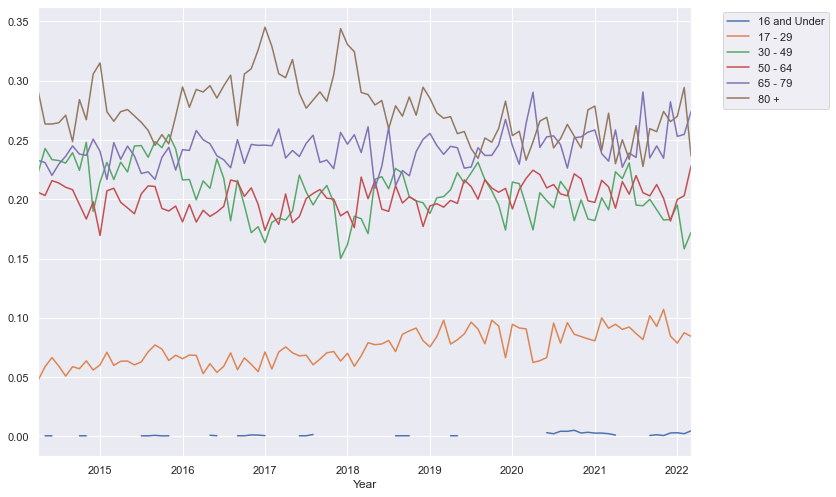

In [10]:
def band_proportions_yearly(df, col='AgeBand'):
    g = df.groupby(
        [df.AdmissionDateTime.dt.year, col]
    )[col].count()
    (g/g.sum(level=0)).unstack(level=1).plot(xlabel='Year')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

def band_proportions_monthly(df, col='AgeBand'):
    g = df.groupby(
        [df.AdmissionDateTime.dt.to_period("M"), col]
    )[col].count()
    (g/g.sum(level=0)).unstack(level=1).plot(xlabel='Year')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    
band_proportions_monthly(df)

<AxesSubplot:xlabel='AdmissionDateTime'>

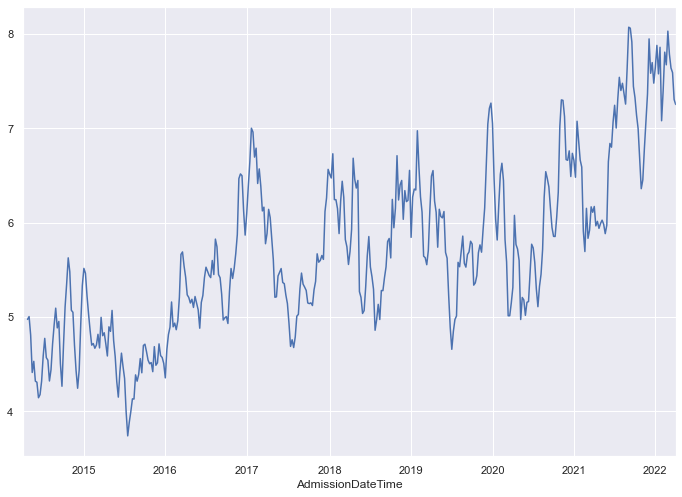

In [11]:
df.groupby(
        df.AdmissionDateTime.dt.to_period("W")
).TotalLOS.mean().rolling(4).mean().plot()

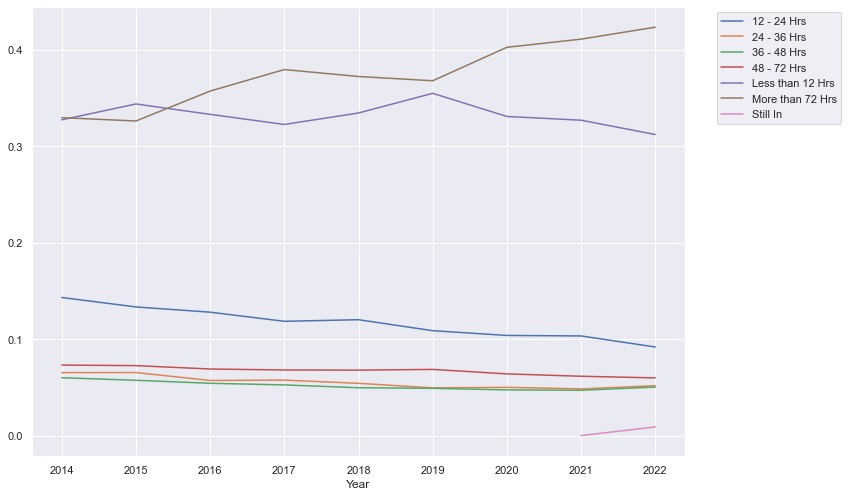

In [12]:
band_proportions_yearly(df, 'LOSBand')

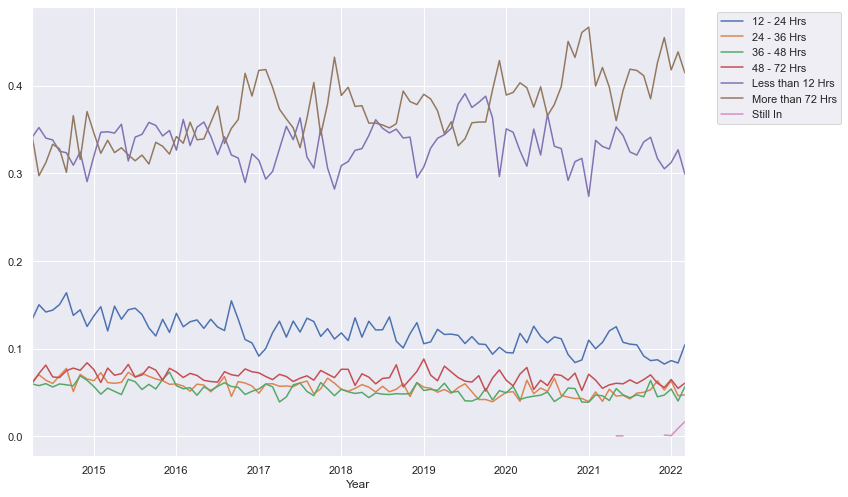

In [13]:
band_proportions_monthly(df, 'LOSBand')

In [21]:
df['ICDLetter'] = df.MainICD10.str[0]
df['ICDNum'] = df.MainICD10.str[1:3]
df['MainICD10_3_Code'] = df.MainICD10.str[:3]

In [199]:
icd10.columns

Index(['Chapter_No', 'Chapter_Desc', 'Group_Code', 'Group_Desc',
       'ICD10_3_Code_Desc'],
      dtype='object')

In [200]:
icd10 = pd.read_hdf('data/icd10.h5', key='ICD10_3_Codes')
icd10_chapter_dict = icd10[['Chapter_No', 'Chapter_Desc']].set_index('Chapter_No').drop_duplicates().Chapter_Desc.to_dict()
icd10_group_dict = icd10[['Group_Code', 'Group_Desc']].set_index('Group_Code').drop_duplicates().Group_Desc.to_dict()

In [183]:
from textwrap import wrap

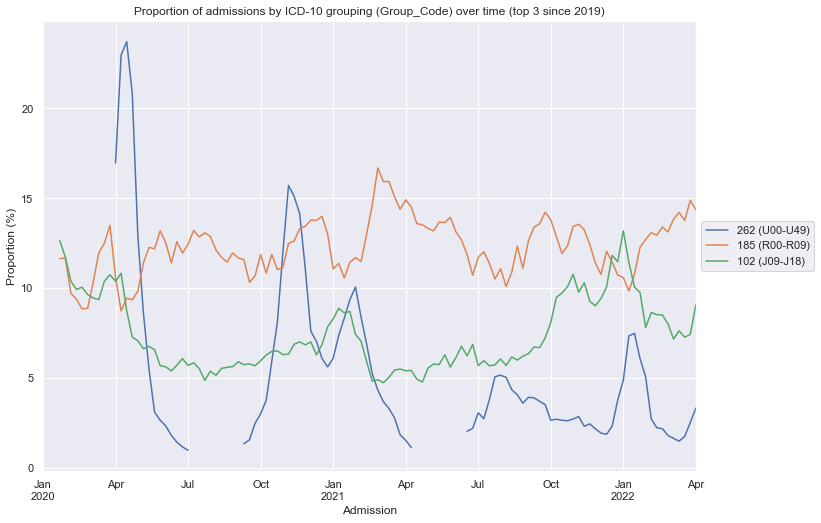

In [418]:
def mainicd10_agg_yearly(
    df,
    icd10,
    grouping="Chapter_No",
    desc="Chapter_Desc",
    label_dict=icd10_chapter_dict,
    topn=5,
    topn_since=2019,
    frequency="W",
):
    # Merge ACP data and ICD10 on 3-codes to get the Chapter/Group code as a column
    merged = df.merge(icd10[grouping], left_on="MainICD10_3_Code", right_index=True)

    # Get the rolling (weekly) sum of counts per grouping instance
    g = (
        merged.groupby([grouping, df.AdmissionDateTime.dt.to_period(frequency)])
        .SpellSerial.count()
        .unstack(0)
        .rolling(4)
        .sum()
    )

    # Normalise by sum
    p = g.div(g.sum(axis=1), axis=0)

    # Get the top chapters based on aggregate proportion since $topn_since
    topn_filter = g.index >= pd.Period(freq=frequency, year=topn_since)
    topn_chapters = p[topn_filter].max(axis=0).nlargest(topn).index

    ax = (p[topn_chapters] * 100).plot(
        xlabel="Admission",
        ylabel="Proportion (%)",
        title=f"Proportion of admissions by ICD-10 grouping ({grouping}) over time (top {topn} since {topn_since})",
    )

    ax.legend(
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        ncol=1,
        fancybox=True,
        # labels=[
        #     "\n".join(wrap(l, 20))
        #     for l in map(label_dict.get, ax.get_legend_handles_labels()[1])
        # ],
    )


mainicd10_agg_yearly(df[df.AdmissionDateTime.dt.year > 2019], icd10, grouping="Group_Code", desc="Group_Desc", label_dict=icd10_group_dict, topn=3)


In [215]:
def ICD_chapters_yearly(df):
    g = df.groupby([df.AdmissionDateTime.dt.year, df.Group_Code]).SpellSerial.count()
    g = (g/g.sum(level=0)).reset_index()
    u = g.groupby('AdmissionDateTime').apply(lambda x: x.nlargest(5, 'SpellSerial')).Group_Code.unique()
    sns.lineplot(data=(g.set_index('Group_Code').loc[u]).reset_index(), y='SpellSerial', x='AdmissionDateTime', hue='Group_Code')

#ICD_chapters_yearly(merged)

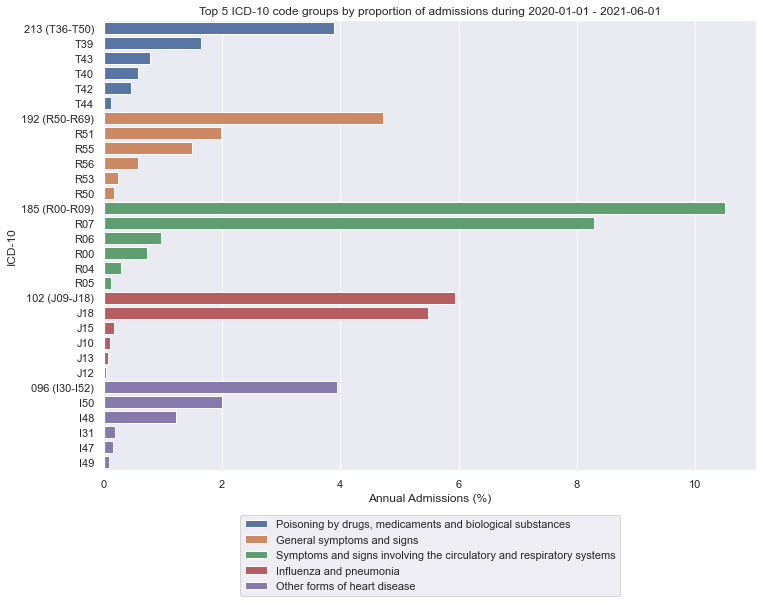

In [343]:
def topn_icd_in_year(df, icd10, datestart, dateend, topn=5, label_dict=icd10_group_dict):
    merged = df.merge(icd10.Group_Code, left_on="MainICD10_3_Code", right_index=True)
    merged = merged[(merged.AdmissionDateTime >= datestart) & (merged.AdmissionDateTime <= dateend)]
    # Get proportions per opcode during the chosen year
    g = merged.groupby(
        [merged.Group_Code, merged.MainICD10_3_Code]
    ).SpellSerial.count()
    g = (g / g.sum())

    # Get the top groups for the year
    top_groups = g.sum(level=0).nlargest(topn).to_frame().reset_index()
    top_groups["MainICD10_3_Code"] = top_groups.Group_Code

    g = (
        g.loc[top_groups.Group_Code]
        .groupby(level=0, group_keys=False)
        .nlargest(topn)
        .reset_index()
    )
    g = pd.concat([top_groups, g])
    g.SpellSerial *= 100

    g = g.merge(icd10[['Group_Code', 'Group_Desc']], right_on='Group_Code', left_on='Group_Code')
    ax = sns.barplot(
        data=g.sort_values(["Group_Code", "SpellSerial"], ascending=False),
        x="SpellSerial",
        y="MainICD10_3_Code",
        hue="Group_Desc",
        dodge=False
    )
    ax.set(
        xlabel="Annual Admissions (%)",
        ylabel="ICD-10",
        title=f"Top {topn} ICD-10 code groups by proportion of admissions during {datestart} - {dateend}",
    )
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), borderaxespad=0.)

topn_icd_in_year(df, icd10, '2020-01-01', '2021-06-01')


<AxesSubplot:title={'center':'Admissions with U07 (Covid-19) as primary diagnosis'}, xlabel='AdmissionDateTime'>

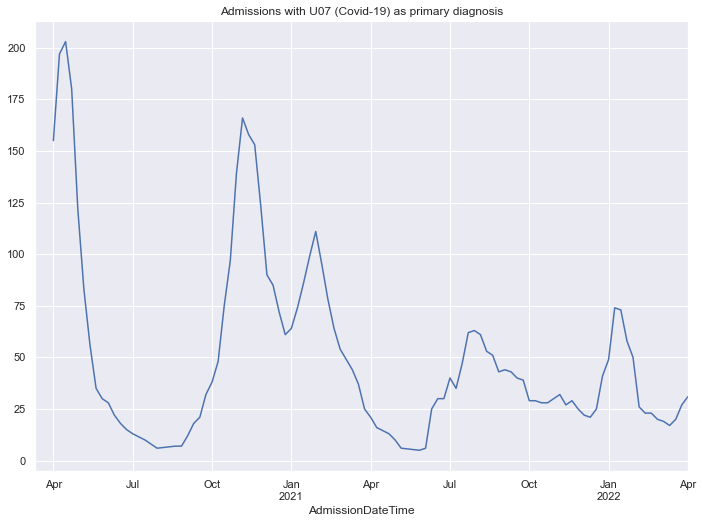

In [348]:
df[df.MainICD10_3_Code == 'U07'].groupby(
    df.AdmissionDateTime.dt.to_period('W')
).size().rolling(4).sum().plot(title='Admissions with U07 (Covid-19) as primary diagnosis')

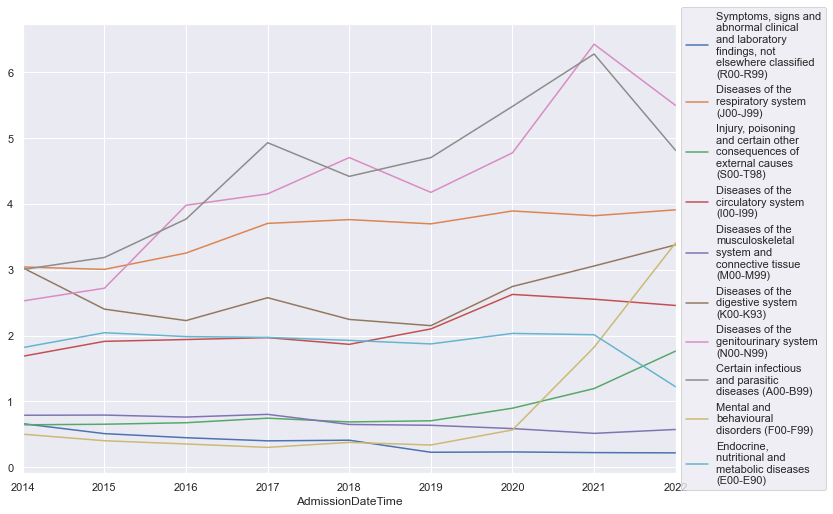

In [375]:
def los_per_icd10(df, icd10):
    merged = df.merge(icd10.Chapter_No, left_on="MainICD10_3_Code", right_index=True)
    top_chapters = merged.groupby(merged.Chapter_No).size().nlargest(10).index
    ax = merged.groupby([merged.AdmissionDateTime.dt.to_period('Y'), merged.Chapter_No]).TotalLOS.median().unstack(level=1)[top_chapters].plot()
    ax.legend(
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        ncol=1,
        fancybox=True,
        labels=[
            "\n".join(wrap(l, 20))
            for l in map(icd10_chapter_dict.get, ax.get_legend_handles_labels()[1])
        ],
    )

los_per_icd10(df, icd10)

In [411]:
def missing_per_icd10_grouping(df, icd10):
    merged = df.merge(icd10.Group_Code, left_on="MainICD10_3_Code", right_index=True)
    top_groups = merged.groupby(merged.Group_Code).size().nlargest(4).index
    missing = merged.set_index(merged.Group_Code).loc[top_groups]
    missing = missing.isna().sum(axis=0)/missing.shape[0]
    missing = missing[missing > 0].sort_values().to_frame(name='proportion')
    return missing

missing_per_icd10_grouping(df, icd10)

,proportion
AandEArrivalTime,0.063133
AandEDepartureTime,0.063133
NewsAuthoredDtm,0.236693
NewsTouchedWhen,0.236693
NewsCreatedWhen,0.236693
c_BP_Systolic,0.259792
c_BP_Diastolic,0.260682
c_Respiration_rate,0.269561
c_O2_saturation,0.271478
c_Temperature,0.272049


<AxesSubplot:xlabel='proportion'>

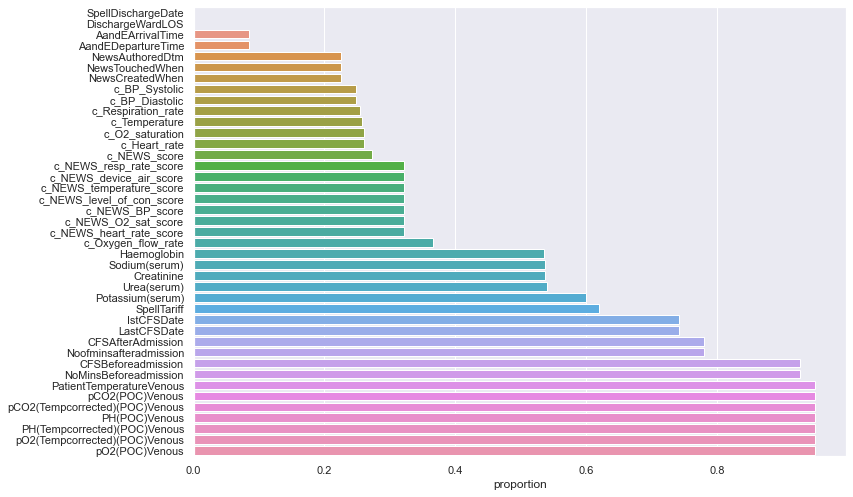

In [388]:
missing = df.isna().sum(axis=0)/df.shape[0]
missing = missing[missing > 0].sort_values().to_frame(name='proportion')
sns.barplot(data=missing, x='proportion', y=missing.index)